In [1]:
! pip install transformers
! pip install torch

### importing libraries 

In [2]:
import torch
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import json
from sklearn.model_selection import train_test_split
from itertools import zip_longest

### defining general variables

In [3]:
#defining global valriables throughout the whole notebook
EPOCH = 10
BATCH_SIZE = 16
MAX_INPUT_LENGTH = 65
MAX_LABEL_LENGTH = 8
MODEL_LINK = "google/flan-t5-small"
FOLD_NUMBER = 1
srl_data_link = '/kaggle/input/srl-w-cluster-number103k/srl_orl-cluster_number.csv'
seed = 0

In [4]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_LINK, legacy=False)
model = T5ForConditionalGeneration.from_pretrained(MODEL_LINK).to('cuda')

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### functions created for reading(get_data) and organize the files (organize_data)

In [5]:
# a funciton to read data off of a database link is here to help getting and organizing data into dataframes
def get_data(address):
    lines = []
    with open(address) as file:
        for line in file:
            x = json.loads(line)
            lines.append(x)
    sentences, orl, sep_sentences = [], [], []
    for i in range(len(lines)):
        sep_sentences.append(lines[i]['sentences'])
        sentences.append(' '.join(lines[i]['sentences']))
        orl.append(lines[i]['orl'])
    dataframe = pd.DataFrame({'sentence': sentences, 'orl': orl, 'sep_sent': sep_sentences})
    return dataframe

# this function is to make a list of the said attribute for later iterations
def list_of(attributes, requested_atr):
    requested_list = []
    for sublist in attributes:
        if sublist[-1] == requested_atr:
            requested_list.append(sublist)
    return requested_list

# this function was made to find target(s)/agent(s) of a dse according to list of attributes
def organize_data(attributes, sentence):
    AGENT, DSE, TARGET = '', '', ''
    target_flag, agent_flag = False, False
    for sublist in attributes:
        if sublist[-1] == 'DSE':
            dse_start = int(sublist[0])
            dse_end = int(sublist[1] + 1)
            DSE += ' '.join(sentence[dse_start:dse_end]) + '|'
            
            
            # looking for the targets and agents of this dse that we have found
            target_flag = False
            for sub_sublist in list_of(attributes, 'TARGET'):
                if sub_sublist[0] == dse_start and int(sub_sublist[1] + 1) == dse_end:
                    target_start = int(sub_sublist[2])
                    target_end = int(sub_sublist[3] + 1)
                    TARGET += ' '.join(sentence[target_start:target_end]) + '|'
                    target_flag = True
            if not target_flag:
                TARGET += ' |'
            
            agent_flag = False
            for sub_sublist in list_of(attributes, 'AGENT'):
                if sub_sublist[0] == dse_start and int(sub_sublist[1] + 1) == dse_end:
                    agent_start = int(sub_sublist[2])
                    agent_end = int(sub_sublist[3] + 1)
                    AGENT += ' '.join(sentence[agent_start:agent_end]) + '|'
                    agent_flag = True
            if not agent_flag:
                AGENT += ' |'
    return AGENT, DSE, TARGET

### a function to call for different links of folders with exact process to extract and organize data

In [6]:
def get_files_of_folder(folder_number):
    folder_number = int()
    folder = f"/kaggle/input/ds-json-format/json_format_dataset/{folder_number}"
    dev_df = get_data(f"{folder}/aaai19srl.dev{folder_number}.conll.json")
    df = get_data(f"{folder}/aaai19srl.train{folder_number}.conll.json")
    test_df = get_data(f"{folder}/aaai19srl.test{folder_number}.conll.json")
    return df, dev_df, test_df
df = get_files_of_folder(FOLD_NUMBER)[0]
dev_df = get_files_of_folder(FOLD_NUMBER)[1]
test_df = get_files_of_folder(FOLD_NUMBER)[2]

### getting training/validation/test data into data frames and dividing each of {agent, target, dse} elements

In [7]:
# df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.train0.conll.json")

for i in range(len(df)):
    agent, dse, target = organize_data(df['orl'][i], df['sep_sent'][i])
    df.loc[i, 'agent'] = agent
    df.loc[i, 'dse'] = dse
    df.loc[i, 'target'] = target

df.drop(columns='sep_sent')

,sentence,orl,agent,dse,target
0,The Kimberley Provincial Hospital said it woul...,"[[6, 8, 0, 3, AGENT], [6, 8, 6, 8, DSE], [6, 8...",The Kimberley Provincial Hospital|,would probably know|,whether one of its patients had Congo Fever|
1,Saeed said indications were that those tests w...,"[[1, 1, 0, 0, AGENT], [1, 1, 1, 1, DSE], [1, 1...",Saeed|,said|,those tests|
2,He said it was his opinion that the patient --...,"[[4, 5, 0, 0, AGENT], [4, 5, 4, 5, DSE], [4, 5...",He|,his opinion|,the patient -- a woman|
3,The woman was admitted to the hospital on Satu...,"[[10, 10, 0, 1, AGENT], [10, 10, 10, 10, DSE],...",The woman|,complaining|,severe joint pains|
4,`` Since our technical equipment is far from p...,"[[22, 22, 2, 4, TARGET], [22, 22, 10, 10, TARG...",Nazarov|,said|,our technical equipment|we|
...,...,...,...,...,...
2444,Benjamin Franklin Federal Savings & Loan Assoc...,"[[9, 9, 8, 8, AGENT], [9, 9, 9, 9, DSE]]",it|,plans|,|
2445,thrift said the restructuring should help it m...,"[[1, 1, 1, 1, DSE], [1, 1, 2, 3, TARGET]]",|,said|,the restructuring|
2446,Details of the restructuring wo n't be made fi...,"[[11, 11, 10, 10, AGENT], [11, 11, 11, 11, DSE]]",regulators|,approve|,|
2447,"Jay Stevens , an analyst with Dean Witter Reyn...","[[12, 12, 11, 11, AGENT], [12, 12, 12, 12, DSE]]",he|,expected|,|


In [8]:
# dev_df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.dev0.conll.json")

for i in range(len(dev_df)):
    agent, dse, target = organize_data(dev_df['orl'][i], dev_df['sep_sent'][i])
    dev_df.loc[i, 'agent'] = agent
    dev_df.loc[i, 'dse'] = dse
    dev_df.loc[i, 'target'] = target

dev_df.drop(columns='sep_sent')

,sentence,orl,agent,dse,target
0,The owner though that the animal was suffering...,"[[2, 2, 0, 1, AGENT], [2, 2, 2, 2, DSE], [2, 2...",The owner|,though|,the animal|
1,"The owner put down the animal , although the v...","[[10, 11, 8, 9, AGENT], [10, 11, 10, 11, DSE],...",the vet|,had forbidden|,him to do so|
2,"GATUNA , Rwanda , July 6 -LRB- AFP -RRB- - Pre...","[[30, 32, 30, 32, DSE], [30, 32, 33, 35, TARGET]]",|,soured relations between|,their neighbouring countries|
3,"The formerly close allies fell out in 1999 , t...","[[4, 5, 0, 3, AGENT], [4, 5, 4, 5, DSE], [4, 5...",The formerly close allies|The formerly close a...,fell out|mounting rivalry|,each| |
4,"In March , Uganda declared Rwanda a hostile na...","[[4, 4, 3, 3, AGENT], [4, 4, 4, 4, DSE], [4, 4...",Uganda| | |,declared|alleged|support|,Rwanda|Kigali|a rival to Museveni in a preside...
...,...,...,...,...,...
1033,He said the independent power segment could gr...,"[[1, 1, 0, 0, AGENT], [1, 1, 1, 1, DSE], [1, 1...",He|We|,said|expect|,the independent power segment|to supply a sign...
1034,Westinghouse also expects its international sa...,"[[2, 2, 0, 0, AGENT], [2, 2, 2, 2, DSE]]",Westinghouse|,expects|,|
1035,Analysts had expected Consolidated to post a s...,"[[2, 2, 0, 0, AGENT], [2, 2, 2, 2, DSE], [2, 2...",Analysts|,expected|,Consolidated to post a slim profit|
1036,"They have to continue to tighten their belts ,...","[[10, 10, 0, 0, TARGET], [10, 10, 10, 10, DSE]...","Craig Kloner , an analyst at Goldman , Sachs &...",said|,They|


In [9]:
# test_df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.test0.conll.json")

for i in range(len(test_df)):
    agent, dse, target = organize_data(test_df['orl'][i], test_df['sep_sent'][i])
    test_df.loc[i, 'agent'] = agent
    test_df.loc[i, 'dse'] = dse
    test_df.loc[i, 'target'] = target

test_df.drop(columns='sep_sent')

,sentence,orl,agent,dse,target
0,Private organizations are also being encourage...,"[[2, 5, 2, 5, DSE], [2, 5, 7, 9, TARGET]]",|,are also being encouraged|,help fight sandstorms|
1,"It is believed that sand from northern areas ,...","[[1, 2, 1, 2, DSE], [1, 2, 4, 25, TARGET]]",|,is believed|,"sand from northern areas , especially the Inne..."
2,Russia favors creation of `` international ins...,"[[1, 1, 0, 0, AGENT], [1, 1, 1, 1, DSE], [1, 1...",Russia|,favors|,creation of `` international instruments '' to...
3,"Moscow , 16 July : The Russian Foreign Ministr...","[[9, 11, 5, 8, AGENT], [9, 11, 9, 11, DSE], [9...",The Russian Foreign Ministry|,has called for|,taking into account Russia 's specific interes...
4,A Foreign Ministry statement in connection wit...,"[[25, 25, 0, 3, AGENT], [25, 25, 25, 25, DSE],...",A Foreign Ministry statement|,reads|,taking into account Russia 's interests|
...,...,...,...,...,...
620,We will have a reasonably flat year this year ...,"[[13, 13, 4, 6, TARGET], [13, 13, 11, 12, AGEN...",Mr. Schwarz|,says|,reasonably flat year|
621,Mr. Schwarz also said costs associated with U....,"[[3, 3, 0, 1, AGENT], [3, 3, 3, 3, DSE], [3, 3...",Mr. Schwarz|,said|,costs associated with U.S. Trust 's planned move|
622,"Esselte AB , the Stockholm office supplies com...","[[12, 12, 0, 8, AGENT], [12, 12, 12, 12, DSE],...","Esselte AB , the Stockholm office supplies com...",proposed|,to acquire the 22 % it does n't own of its U.S...
623,A committee of outside directors for the Garde...,"[[20, 20, 18, 19, AGENT], [20, 20, 20, 20, DSE]]",the parent|,asked|,|


### Getting evaluation data into df and dividing each of {agent, target, dse} elements

In [10]:
def pipeDivider(pipedString):
    listOfItems = []
    listOfItems = pipedString.split('|')[:-1]
    return listOfItems

In [11]:
# function which will write prompt for the model according to the sentence and the items in it
def create_prompt(input_df):
    output_df = pd.DataFrame(columns=['target_prompt', 'agent_prompt', 'target', 'agent'])
    for i in range(len(input_df)):
        dse_list, target_list, agent_list = [], [], []
        dse_list = pipeDivider(str(input_df.iloc[i]['dse']))
        target_list = pipeDivider(str(input_df.iloc[i]['target']))
        agent_list = pipeDivider(str(input_df.iloc[i]['agent']))
        for j in range(len(dse_list)):
            last_row = int(len(output_df))+1
            output_df.loc[last_row, 'target_prompt'] = f"Sentence is: {input_df.iloc[i]['sentence']} Find target for this dse: {dse_list[j]}"
            output_df.loc[last_row, 'agent_prompt'] = f"Sentence is: {input_df.iloc[i]['sentence']} Find agent for this dse: {dse_list[j]}"
            output_df.loc[last_row, 'target'] = target_list[j]
            output_df.loc[last_row, 'agent'] = agent_list[j]
    return output_df
train_df = create_prompt(df)

### Change the sentence and dse into a prompt according to information in that row 
#### change will be applied on all three data frames {train, test, validation}

In [12]:
dev_df = create_prompt(dev_df).reset_index(drop=True)
train_df = create_prompt(df).reset_index(drop=True)
test_df = create_prompt(test_df).reset_index(drop=True)

In [13]:
from torch.utils.data import DataLoader, Dataset
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length4text, max_length4label):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length4text = max_length4text
        self.max_length4label = max_length4label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        agent_prompt = self.data['agent_prompt'][idx]
        target_prompt = self.data['target_prompt'][idx]
        agent = self.data['agent'][idx]
        target = self.data['target'][idx]
        # tokenizing agent prompt
        agent_prompt_encoding = self.tokenizer(agent_prompt, truncation=True, padding='max_length', max_length=self.max_length4text, return_tensors='pt').to("cuda")
        # tokenizing target prompt
        target_prompt_encoding = self.tokenizer(target_prompt, truncation=True, padding='max_length', max_length=self.max_length4text, return_tensors='pt').to("cuda")
        # tokenizing agent
        agent_encoding = self.tokenizer(agent, truncation=True, padding='max_length', max_length=self.max_length4label, return_tensors='pt').to("cuda")
        # tokenizing target
        target_encoding = self.tokenizer(target, truncation=True, padding='max_length', max_length=self.max_length4label, return_tensors='pt').to("cuda")
        return {
            # agent prompt
            'agent_input_id': agent_prompt_encoding['input_ids'].squeeze(),
            'agent_attention_mask': agent_prompt_encoding['attention_mask'].squeeze(),
            # target prompt
            'target_input_id': target_prompt_encoding['input_ids'].squeeze(),
            'target_attention_mask': target_prompt_encoding['attention_mask'].squeeze(),
            #agent
            'agent_id': agent_encoding['input_ids'].squeeze(),
            'agent_mask': agent_encoding['attention_mask'].squeeze(),
            #target
            'target_id': target_encoding['input_ids'].squeeze(),
            'target_mask': target_encoding['attention_mask'].squeeze()
        }

In [14]:
# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
def f1_calculator(pred_list, actual_list):
    cleaned_pred, cleaned_actual = [], []
    matched = 0
    for i in range(len(pred_list)):
        for j in range(len(actual_list)):
            if actual_list[j] in pred_list:
                matched += 1
        cleaned_pred.extend(pred_list)
        cleaned_actual.extend(actual_list)
    
    prediction_len = len(cleaned_pred)
    actual_len = len(cleaned_actual)
    print(f'matched: {matched}, prediction_len:{prediction_len}, actual_len:{actual_len} \n')
    try:
        precision = (matched / prediction_len)
        recall = (matched / actual_len)
        f1 = (2 * (precision * recall)) / (precision + recall)
    except:
        f1 = 0
    return f1

In [16]:
def evaluate_model(model, dataloader, prompt_type):
    if prompt_type == 'target':
        id_type = 'target_input_id'
        attention_type = 'target_attention_mask'
        output_type = 'target_id'
    elif prompt_type == 'agent':
        id_type = 'agent_input_id'
        attention_type = 'agent_attention_mask'
        output_type = 'agent_id'
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        true_counted, prediction_counted, actual_counted = 0,0,0
        matched, prediction_len, actual_len = 0,0,0
        actual_list, prediction_list, f1 = [], [], []
        for batch_idx, batch in enumerate(dataloader):
            # Move data to the specified device
            # batch = {key: value.to('cuda') for key, value in batch.items()}

            # Forward pass
            ids = batch[id_type]
            mask = batch[attention_type]
            output_id = batch[output_type]
            
            actuals = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in output_id]
            
            generated_output = generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=64, 
              )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_output]
            
            actual_list.extend(actuals)
            prediction_list.extend(preds)
            
    return f1_calculator(prediction_list, actual_list)

In [17]:
f1_scores_target, f1_scores_agent = [], []
#           data_loader:train,v_data_loader:validation
def train_data(data_loader, v_data_loader):
    data_list = []
    model.train()
    for epoch in range(EPOCH):
        losses = []
        for batch in data_loader:

            agent_input = batch['agent_input_id']
            agent_attention_mask = batch['agent_attention_mask']

            target_input = batch['target_input_id']
            target_attention_mask = batch['target_attention_mask']

            agent_id = batch['agent_id']
            agent_mask = batch['agent_mask']

            target_id = batch['target_id']
            target_mask = batch['target_mask']

            optimizer.zero_grad()

            agent_output = model(agent_input, attention_mask=agent_attention_mask, labels=agent_id)
            target_output = model(target_input, attention_mask=target_attention_mask, labels=target_id)
            
            # created just for examination
            # has no contribution to accuracy of model output
            temprorarly_pd = pd.DataFrame([{
                'actual_agent': [tokenizer.decode(a) for a in agent_input],
                'agent_model_output': agent_output,
                'actual_target': [tokenizer.decode(c) for c in target_input],
                'target_model_output': target_output
            }])
            # 
            # 
            
            agent_loss = agent_output.loss
            target_loss = target_output.loss
            losses.append(agent_loss.item())
            losses.append(target_loss.item())

            agent_loss.backward()
            target_loss.backward()
            optimizer.step()
            

        f1_4_target = evaluate_model(model, v_data_loader, 'target')
        f1_4_agent = evaluate_model(model, v_data_loader, 'agent')
        
        f1_scores_target.append(f1_4_target)
        f1_scores_agent.append(f1_4_agent)
        
        # report the results of training function.
        print(f'loss: {np.mean(losses)}, f1 for target:{f1_4_target}, f1 for agent:{f1_4_agent} \n end of epoch{epoch}. \n')

# By this box, mpqa/orl data is ready to be combined with different forms of clustering being applied on the rest of the data

### .
### .
### .
### .
## chosing randomly out of SRL_without_anchors for calculating the results
### .
### .
### .
### .

In [21]:
srl = pd.read_csv(srl_data_link)
agents, targets, verbs, sentences, cluster_number = [], [], [], [], []
for i in range(len(srl)):
    
    #single line of data is selected from df
    line = srl.iloc[i]
    
    #check for both ARGS, 
    #if both are empty skips that line.
    #if either one of the args is filled-
    #-process continues.
    if line['ARG0'] or line['ARG1']:
        if line['ARG0']:
            agents.append(line['ARG0'])
        else:
            agents.append("")
        if line['ARG1']:
            targets.append(line['ARG1'])
        else:
            targets.append("")
        sentences.append(line['Sentence'])
        verbs.append(line['Predicate'])
        cluster_number.append(line['Cluster_Number'])

srl_df = pd.DataFrame({'sentences': sentences, 'verbs': verbs, 'agents': agents, 'targets': targets, 'cluster_no':cluster_number}, dtype='object').fillna('')
srl_df

/tmp/ipykernel_30/561452967.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  srl_df = pd.DataFrame({'sentences': sentences, 'verbs': verbs, 'agents': agents, 'targets': targets, 'cluster_no':cluster_number}, dtype='object').fillna('')


,sentences,verbs,agents,targets,cluster_no
0,"Pierre Vinken , 61 years old , will join the b...",join,"Pierre Vinken , 61 years old ,",the board,4
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...",is,,Mr. Vinken,4
2,"Mr. Vinken is chairman of Elsevier N.V. , the ...",publishing,group,,4
3,"Rudolph Agnew , 55 years old and former chairm...",named,,"Rudolph Agnew , 55 years old and former chairm...",2
4,A form of asbestos once used to make Kent ciga...,used,,A form of asbestos,2
...,...,...,...,...,...
103171,`` We emphasize discipline because we know tha...,said,"Andrew Mlangeni , another early Umkhonto leade...",We emphasize discipline because we know that t...,7
103172,`` We want to see Nelson Mandela and all our c...,want,We,to see Nelson Mandela and all our comrades out...,8
103173,`` We want to see Nelson Mandela and all our c...,see,We,Nelson Mandela and all our comrades out of prison,8
103174,`` We want to see Nelson Mandela and all our c...,see,we,them,8


In [22]:
agent_prompts, agents, target_prompts, targets, cluster_no = [], [], [], [], []
for i in range(len(srl_df)):
    line = srl_df.iloc[i]
    agent_prompts.append(f" sentence is: {line['sentences']} find agent for this verb: {line['verbs']}")
    agents.append(line['agents'])
    target_prompts.append(f" sentence is: {line['sentences']} find target for this verb: {line['verbs']}")
    targets.append(line['targets'])
    cluster_no.append(line['cluster_no'])
srl_df = []
srl_df = pd.DataFrame({'agent_prompt': agent_prompts, 'agent': agents, 'target_prompt': target_prompts, 'target': targets, 'cluster_no':cluster_no})

#### randomly selecting number of this dataframe to be fed into the model

In [24]:
def random_sample_df(df, num_rows, seed=None):
    # Check if num_rows is larger than the available number of rows in the DataFrame
    if num_rows > len(df):
        raise ValueError(f"Requested {num_rows} rows, but the DataFrame only contains {len(df)} rows.")
    
    # Sample the DataFrame and return the result
    sampled_df = df.sample(n=num_rows, random_state=seed)
    return sampled_df

def random_sample_from_all_clusters(df, num_rows_per_cluster, cluster_column, seed=None):
    # Check if the cluster_column exists in the DataFrame
    if cluster_column not in df.columns:
        raise ValueError(f"Column '{cluster_column}' not found in DataFrame.")

    # Create an empty list to hold the sampled data for each cluster
    sampled_dfs = []

    # Group the DataFrame by the cluster column
    grouped = df.groupby(cluster_column)

    # Iterate over each cluster and sample rows
    for cluster, group in grouped:
        # Check if the group has enough rows to sample
        if len(group) < num_rows_per_cluster:
            raise ValueError(f"Cluster '{cluster}' has only {len(group)} rows, but {num_rows_per_cluster} were requested.")
        
        # Sample the rows from the current cluster
        sampled_group = group.sample(n=num_rows_per_cluster, random_state=seed)
        sampled_dfs.append(sampled_group)

    # Concatenate the sampled DataFrames for each cluster
    sampled_df = pd.concat(sampled_dfs).reset_index(drop=True)

    return sampled_df


srl_train_2k = random_sample_from_all_clusters(srl_df, 200, 'cluster_no', seed)
srl_train_2k

,agent_prompt,agent,target_prompt,target,cluster_no
0,sentence is: Not one thing in the house is wh...,,sentence is: Not one thing in the house is wh...,,0
1,sentence is: The timing for change was right ...,,sentence is: The timing for change was right ...,The timing for change,0
2,sentence is: Older properties that still have...,,sentence is: Older properties that still have...,Older properties that still have a 195s image,0
3,sentence is: In the end politics got in the w...,,sentence is: In the end politics got in the w...,,0
4,"sentence is: Sen. DeConcini said , `` When al...",I,"sentence is: Sen. DeConcini said , `` When al...",to be fully exonerated,0
...,...,...,...,...,...
1995,sentence is: In early trading in Hong Kong Tu...,,sentence is: In early trading in Hong Kong Tu...,gold at $ 376.8 an ounce,9
1996,sentence is: Carat will receive its WCRS stak...,WCRS,sentence is: Carat will receive its WCRS stak...,the 5 % Carat stake that,9
1997,"sentence is: Results of the Monday , October ...",,"sentence is: Results of the Monday , October ...","of short - term U.S. government bills , sold a...",9
1998,sentence is: The $ 196.7 million provided for...,,sentence is: The $ 196.7 million provided for...,of a Lockheed P - 3 surveillance aircraft and ...,9


In [25]:
def combine_and_shuffle(df1, df2, seed=None):
    """
    Combines two DataFrames with the same columns and shuffles the rows.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A new DataFrame with rows from both DataFrames shuffled.
    """
    # Combine the two DataFrames using pd.concat
    combined_df = pd.concat([df1, df2], ignore_index=True)
    
    # Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1, random_state=seed).reset_index(drop=True)
    
    return shuffled_df
orl_srl = combine_and_shuffle(train_df, srl_train_2k,)
orl_srl

,target_prompt,agent_prompt,target,agent,cluster_no
0,"sentence is: Most murders are state crimes , ...","sentence is: Most murders are state crimes , ...",any federal capital - punishment law to be mor...,,6.0
1,Sentence is: The protocol faced danger of bein...,Sentence is: The protocol faced danger of bein...,abruptly withdraw from the climate change treaty,the U.S,NaN
2,Sentence is: Some administration officials won...,Sentence is: Some administration officials won...,she paints doomsday scenarios,Some administration officials,NaN
3,"Sentence is: In direct response , the American...","Sentence is: In direct response , the American...",pro-American,generals,NaN
4,"sentence is: Despite his racial advantage , t...","sentence is: Despite his racial advantage , t...",one 's pantry,,7.0
...,...,...,...,...,...
5530,sentence is: There was no cost estimate for t...,sentence is: There was no cost estimate for t...,no cost estimate for the second phase,,5.0
5531,"Sentence is: It 's odd , however , that in rep...","Sentence is: It 's odd , however , that in rep...",,he,NaN
5532,sentence is: The fact is that as a savings or...,sentence is: The fact is that as a savings or...,your money,the insurance company,3.0
5533,Sentence is: The meeting is the first since th...,Sentence is: The meeting is the first since th...,the initiative,their leaders,NaN


In [26]:
# Create a data loader for TRAIN dataframe 
train_dataset = CustomDataset(orl_srl, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
train_data_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)

# Create a data loader for EVALUATION dataframe
val_dataset = CustomDataset(dev_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
val_data_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False)

# Create a data loader for TEST dataframe
test_dataset = CustomDataset(test_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
test_data_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=False)



In [27]:
train_data(train_data_loader, val_data_loader)

matched: 1249452, prediction_len:2277081, actual_len:2277081 

matched: 1812309, prediction_len:2277081, actual_len:2277081 

loss: 0.8564957463952331, f1 for target:0.5487077534791253, f1 for agent:0.7958913187541418 
 end of epoch0. 

matched: 1444113, prediction_len:2277081, actual_len:2277081 

matched: 1884741, prediction_len:2277081, actual_len:2277081 

loss: 0.24341677754546778, f1 for target:0.6341948310139165, f1 for agent:0.8277004638833665 
 end of epoch1. 

matched: 1388280, prediction_len:2277081, actual_len:2277081 

matched: 1877196, prediction_len:2277081, actual_len:2277081 

loss: 0.15891744857492474, f1 for target:0.6096752816434725, f1 for agent:0.8243870112657389 
 end of epoch2. 

matched: 1350555, prediction_len:2277081, actual_len:2277081 

matched: 1822872, prediction_len:2277081, actual_len:2277081 

loss: 0.11317705571640692, f1 for target:0.5931080185553347, f1 for agent:0.8005301524188204 
 end of epoch3. 

matched: 1394316, prediction_len:2277081, actual_

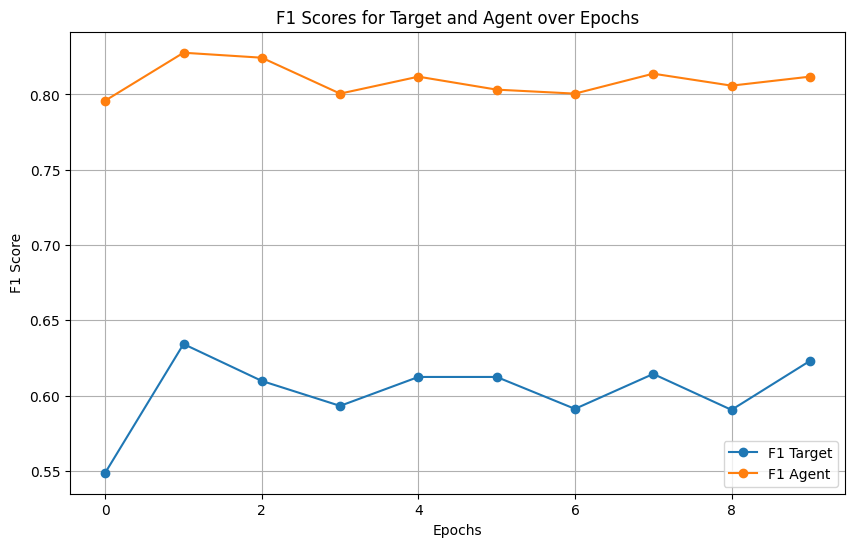

In [28]:
import matplotlib.pyplot as plt
# Plot F1 scores for target and agent
epochs = range(0, EPOCH)

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores_target, label='F1 Target', marker='o')
plt.plot(epochs, f1_scores_agent, label='F1 Agent', marker='o')

plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Target and Agent over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
target_accuracy = evaluate_model(model, val_data_loader, 'target')
agent_accuracy = evaluate_model(model, val_data_loader, 'agent')
print(f'f1 Agent: {agent_accuracy}. f1 Target: {target_accuracy}\n\n----------------------')

matched: 1418460, prediction_len:2277081, actual_len:2277081 

matched: 1848525, prediction_len:2277081, actual_len:2277081 

f1 Agent: 0.8117958913187542. f1 Target: 0.6229290921139827

----------------------


### mpqa fold 0 to 4 
#### average f1 score for agent and target
fold0_agent = 0.8197088465845465
fold0_target = 0.5834266517357223

fold1_agent = 0.7872340425531915
fold1_target = 0.5599104143337066

fold2_agent = 0.7849944008958566
fold2_target = 0.568868980963046

fold3_agent = 0.7950727883538634
fold3_target = 0.5789473684210527

fold4_agent = 0.7939529675251961
fold4_target = 0.571108622620380